<a href="https://colab.research.google.com/github/LauJohansson/GAN_Horse2Zebra_and_MNIST/blob/master/CycleGAN_Horse2Zebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Adversarial Network - CycleGAN - Horses to zebras

In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict

from skimage.io import imread

from skimage.transform import resize
from IPython.display import clear_output
from torch import optim

from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
if not os.path.exists('./horse2zebra'):
  import gdown
  url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
  gdown.download(url, './horse2zebra.zip', quiet=False)
  !unzip ./horse2zebra.zip > /dev/null

In [4]:
#from google.colab import drive
#drive.mount('./gdrive')

# Data preprocessing

## Train data

In [5]:
#Save filenames
for root, dirs, files in os.walk('./horse2zebra'):
    if root.endswith('/train/A'):
        filenames_horses=files
    if root.endswith('/train/B'):
        filenames_zebras=files

#Sort filenames
filenames_horses_sort=sorted(filenames_horses)
filenames_zebras_sort=sorted(filenames_zebras)

horses_root='./horse2zebra/train/A'
zebras_root='./horse2zebra/train/B'

horses_train=[]
zebras_train=[]

#Save all pictures
for i in range(len(filenames_horses_sort)):
          #images_train.append(imread(os.path.join(horses_root, filenames_horses_sort[i])))
          horses_train.append(Image.open(os.path.join(horses_root, filenames_horses_sort[i])).convert('RGB'))

for i in range(len(filenames_zebras_sort)):
          #images_train.append(imread(os.path.join(horses_root, filenames_horses_sort[i])))
          zebras_train.append(Image.open(os.path.join(zebras_root, filenames_zebras_sort[i])).convert('RGB'))


In [6]:
size = (128, 128)
horses_train = [x.resize(size) for x in horses_train]
zebras_train = [y.resize(size) for y in zebras_train]

print('Loaded %d images' % len(horses_train))

Loaded 1067 images


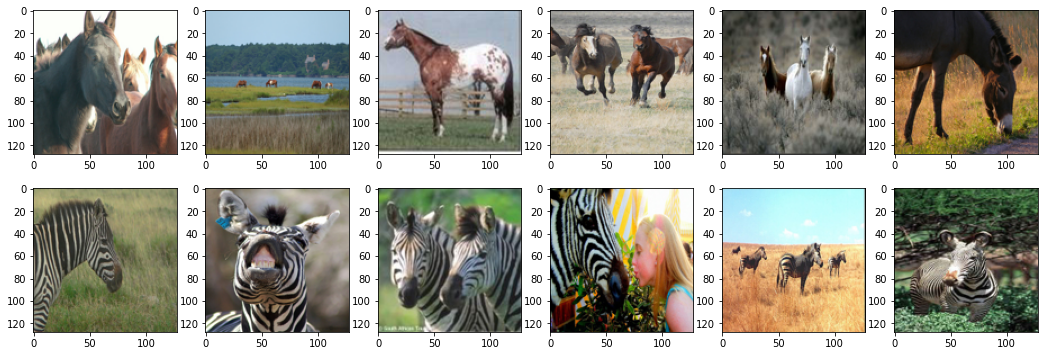

In [7]:
plt.rcParams['figure.figsize'] = [18, 6]

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(horses_train[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(zebras_train[i])
plt.show();

## Test data

In [8]:
#Save filenames
for root, dirs, files in os.walk('./horse2zebra'):
    if root.endswith('/test/A'):
        filenames_horses=files
    if root.endswith('/test/B'):
        filenames_zebras=files

#Sort filenames
filenames_horses_sort=sorted(filenames_horses)
filenames_zebras_sort=sorted(filenames_zebras)

horses_root='./horse2zebra/test/A'
zebras_root='./horse2zebra/test/B'

horses_test=[]
zebras_test=[]

#Save all images
for i in range(len(filenames_horses_sort)):
          #images_train.append(imread(os.path.join(horses_root, filenames_horses_sort[i])))
          horses_test.append(Image.open(os.path.join(horses_root, filenames_horses_sort[i])).convert('RGB'))

for i in range(len(filenames_zebras_sort)):
          #images_train.append(imread(os.path.join(horses_root, filenames_horses_sort[i])))
          zebras_test.append(Image.open(os.path.join(zebras_root, filenames_zebras_sort[i])).convert('RGB'))


In [9]:
size = (128, 128)
horses_test = [x.resize(size) for x in horses_test]
zebras_test = [y.resize(size) for y in zebras_test]

print('Loaded %d images' % len(horses_test))

Loaded 120 images


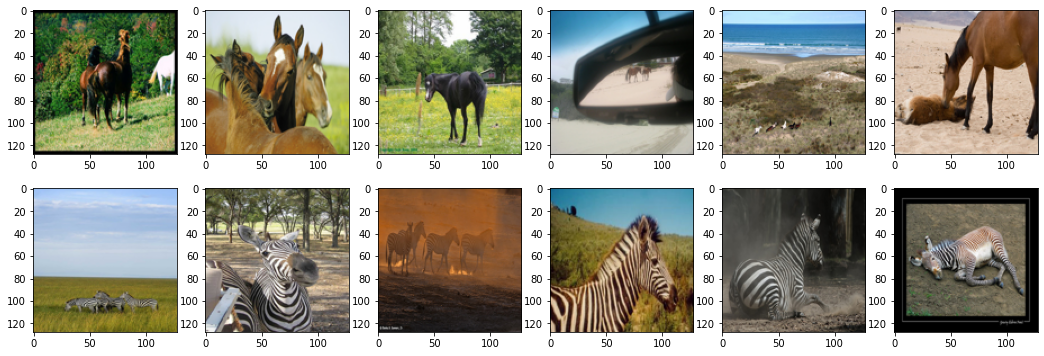

In [10]:
plt.rcParams['figure.figsize'] = [18, 6]

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(horses_test[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(zebras_test[i])
plt.show();

# Handle unequal datasize and shuffle data

In [11]:
print("Number of horse training images {}".format(len(horses_train)))
print("Number of zebras training images {}".format(len(zebras_train)))

print("Number of horse test images {}".format(len(horses_test)))
print("Number of zebras test images {}".format(len(zebras_test)))


Number of horse training images 1067
Number of zebras training images 1334
Number of horse test images 120
Number of zebras test images 140


Chooses to random shuffle all data, and let zebras training size be equal to horse training size.

In [12]:
#import random
#random.shuffle(horses_test)
#random.shuffle(zebras_test)

In [13]:
import random
random.shuffle(horses_train)
random.shuffle(zebras_train)
random.shuffle(horses_test)
random.shuffle(zebras_test)

zebras_train=zebras_train[0:len(horses_train)]
print("Number of horse training images {}".format(len(horses_train)))
print("Number of zebras training images {}".format(len(zebras_train)))

print("Number of horse test images {}".format(len(horses_test)))
print("Number of zebras test images {}".format(len(zebras_test)))


Number of horse training images 1067
Number of zebras training images 1067
Number of horse test images 120
Number of zebras test images 140


# Pytorch dataloader

Let's use PyTorch data loader to iterate images in batches. Notice that images are loaded in the format $N\times H\times W\times C$, but PyTorch prefers $N\times C\times H\times W$. We change the array order.

In [14]:
ix_train = np.random.choice(len(horses_train),len(horses_train),False)#4000
ix_test = np.random.choice(len(horses_test),len(horses_test),False)#100

In [15]:
horses_train=list( horses_train[i] for i in ix_train )
zebras_train=list( zebras_train[i] for i in ix_train )

horses_test=list( horses_test[i] for i in ix_test )
zebras_test=list( zebras_test[i] for i in ix_test )

In [16]:
#https://discuss.pytorch.org/t/pytorch-pil-to-tensor-and-vice-versa/6312/9
horses_train_to_tensor = [transforms.ToTensor()(x) for x in horses_train]
zebras_train_to_tensor = [transforms.ToTensor()(y) for y in zebras_train]

In [17]:
horses_test_to_tensor = [transforms.ToTensor()(x) for x in horses_test]
zebras_test_to_tensor = [transforms.ToTensor()(y) for y in zebras_test]

In [18]:
batch_size = 1

In [19]:
data_tr = DataLoader(list(zip(horses_train_to_tensor, zebras_train_to_tensor)), batch_size=batch_size, shuffle=True)#

In [20]:
data_val = DataLoader(list(zip(horses_test_to_tensor, zebras_test_to_tensor)), batch_size=batch_size, shuffle=True)

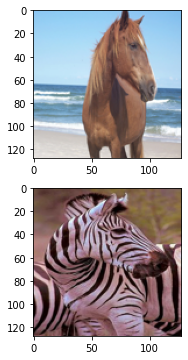

In [21]:
X, Y = next(iter(data_tr))

for i in range(batch_size):
    plt.subplot(2, batch_size, i+1)
    plt.imshow(X[i].permute(1,2,0).numpy())

    plt.subplot(2, batch_size, i+1+batch_size)
    plt.imshow(Y[i].permute(1,2,0).numpy())
plt.show();


# Given classes

In [22]:
n_blocks=6

In [23]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=n_blocks):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

# Hyperparameters

In [24]:
alpha=0.2 #LeakyReLU slope
beta=0.5 #Beta1 in Adam
lr_G=0.0001 #learningrate in Adam
lr_D=0.0002 #learningrate in Adam
lambda_cycle=10
lambda_identity=5

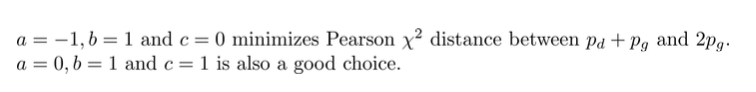

In [25]:
#LSGAN LOSS
a=-1
b=1
c=0

#a=0
#b=1
#c=1

# Make discriminator

In [26]:
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
      
        self.conv = nn.Sequential(
            nn.Conv2d(3,f,4,stride=2,padding=1), #1 layer
            nn.InstanceNorm2d(f),
            nn.LeakyReLU(alpha),
            nn.Conv2d(f,f*2,4,stride=2,padding=1), #2 layer 
            nn.InstanceNorm2d(f*2),
            nn.LeakyReLU(alpha),
            nn.Conv2d(f*2,f*4,4,stride=2,padding=1), #3 layer
            nn.InstanceNorm2d(f*4),
            nn.LeakyReLU(alpha),
            nn.Conv2d(f*4,f*8,4,stride=1,padding=1), #4 layer 
            nn.InstanceNorm2d(f*8),
            nn.LeakyReLU(alpha),


            nn.Conv2d(f*8,1,4,stride=1,padding=1), #5 layer
            #nn.InstanceNorm2d(1),
            #nn.Sidmoid? #Maybe this should be erased   #Because we use .Logsigmoid
        )
        
    def forward(self, x):
        return self.conv(x)

#Loss (LSGAN)

Inspiration: https://wiseodd.github.io/techblog/2017/03/02/least-squares-gan/

In [27]:
#Wrong use of LSGAN loss
#def LSGAN_loss_D(input_1,input_2):
#  return 0.5*torch.mean((input_1 - b)**2) + 0.5* torch.mean((input_2-a)**2)

In [28]:
#Wrong use of LSGAN loss
#def LSGAN_loss_G(input_1):
# return 0.5 * torch.mean((input_1 - c)**2)

In [29]:
def Imloss(pred,target):
  crit=nn.L1Loss()
  #crit=nn.BCEWithLogitsLoss()
  return crit(pred,target)

In [30]:
def LSGAN_loss_Dt(input_1):
    return 0.5*torch.mean((input_1 - b)**2)

def LSGAN_loss_Df(input_2):
    return 0.5* torch.mean((input_2 - a)**2)

def LSGAN_loss_G(input_1):
  return 0.5*torch.mean((input_1 - c)**2)

def Imloss(pred,target):
  crit=nn.L1Loss()

  return crit(pred,target)

#Train

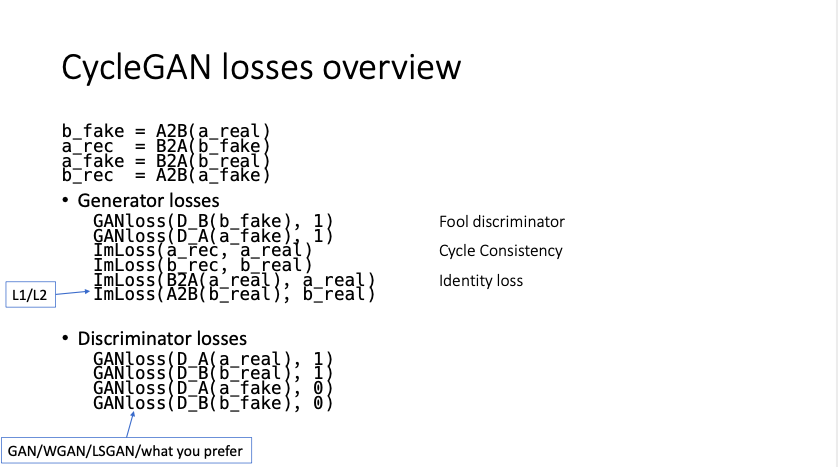

Picture taken from slides presentated by Morten Hannemose.

In [31]:
def train(A2B,B2A,Dis_A,Dis_B, opt_dis_A,opt_dis_B,opt_A2B,opt_B2A, epochs, data_tr, data_val):
  X_val, Y_val = next(iter(data_val))

  

  #Lists to keep track of losses
  G_losses=[]
  D1_losses=[]
  D2_losses=[]

  for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch+1, epochs))

    #Scale from [0:1] -> [-1:1]
    X_val = X_val*2-1
    Y_val = Y_val*2-1

    A2B.train()
    B2A.train()
    Dis_A.train()
    Dis_B.train()

    ######## TRAINING ########
    for X_batch, Y_batch in data_tr:
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      #Scale from [0:1] -> [-1:1]
      X_batch = X_batch*2-1
      Y_batch = Y_batch*2-1
  

      # set parameter gradients to zero
      opt_A2B.zero_grad()
      opt_B2A.zero_grad()
      opt_dis_A.zero_grad()
      opt_dis_B.zero_grad()


      #Initialize (from slide 8 i lecture 3.2)
      
      #real images = X/Y batch
      a_real=X_batch
      b_real=Y_batch

      #Relates to horse
      b_fake = A2B(a_real) 
      a_rec = B2A(b_fake)

      #Relates to zebra
      a_fake = B2A(b_real) 
      b_rec = A2B(a_fake)


      ######PROCESS 1####### (Stort billede på slide 7 i lecture 3.2)
      
      ####Discriminator ####
      output1=Dis_A(a_real) #Pass real Horse to discriminator A...
      loss1=LSGAN_loss_Dt(output1) 

      output2=Dis_B(b_real) #Pass real Zebra to discriminator B...
      loss2=LSGAN_loss_Dt(output2) 
      

      output3=Dis_A(a_fake.detach()) #Pass fake Horse (generated by B2A) to discriminator A...
      loss3=LSGAN_loss_Df(output3) 
      

      output4=Dis_B(b_fake.detach()) #Pass fake Zebra (generated by A2B) to discriminator B...
      loss4=LSGAN_loss_Df(output4) 
      

      loss_dis_A_total=loss1+loss3 #Add all losses for discriminator A
      loss_dis_A_total.backward() 
      opt_dis_A.step() #Update Discriminator A
      
      loss_dis_B_total=loss2+loss4 #Add all losses for discriminator B
      loss_dis_B_total.backward()
      opt_dis_B.step() #Update Discriminator B


      ####GENERATOR ####
      ##FOOL discriminator
      output5=Dis_B(b_fake) #Pass fake Zebra (generated by A2B) to discriminator B...
      loss5=LSGAN_loss_G(output5)
      

      output6=Dis_A(a_fake) #Pass fake Horse (generated by B2A) to discriminator A...
      loss6=LSGAN_loss_G(output6)
      

      ##Cycle consistency
      loss7=Imloss(b_rec,b_real) #Calculate loss between reconstructed and real Zebra
      loss8=Imloss(a_rec,a_real) #Calculate loss between reconstructed and real Horse
      

      ##Identity loss
      loss9=Imloss(B2A(a_real),a_real) #Calculate loss between real Horse and when real Horse is passed to B2A       
      loss10=Imloss(A2B(b_real),b_real) #Calculate loss between real Zebra and when real Zebra is passed to A2B 
      

      loss_total=loss5+loss6+lambda_cycle*loss7+lambda_cycle*loss8+lambda_identity*loss9+lambda_identity*loss10 #Add all generator losses
      loss_total.backward()
      opt_A2B.step() #Update generator A2B
      opt_B2A.step() #Update generator B2A

    
    ######## TEST ########

    A2B.eval()
    B2A.eval()
    Dis_A.eval()
    Dis_B.eval()


    #show intermediate results
    #Horse2zebra
    Original_horse=X_val
    Fake_horse=A2B(X_val.to(device))
    Recovered_horse=B2A(Fake_horse).detach().cpu()
    Identity_horse=B2A(X_val.to(device)).detach().cpu()

    #Horse2zebra
    Original_zebra=Y_val
    Fake_Zebra=B2A(Y_val.to(device)).detach().cpu()
    Recovered_zebra=A2B(Fake_Zebra.to(device)).detach().cpu()
    Identity_zebra=A2B(Y_val.to(device)).detach().cpu()


    #Scale from [-1:1] -> [0:1]
    X_val = X_val/2+0.5
    Fake_horse = Fake_horse/2+0.5
    Recovered_horse = Recovered_horse/2+0.5
    Identity_horse = Identity_horse/2+0.5

    Y_val = Y_val/2+0.5
    Fake_Zebra = Fake_Zebra/2+0.5
    Recovered_zebra = Recovered_zebra/2+0.5
    Identity_zebra = Identity_zebra/2+0.5


    clear_output(wait=True)

    plt.figure(1)
    for k in range(batch_size):
        #Plotting horses
        plt.subplot(2, 4, k+1)
        plt.imshow(X_val[k].permute(1,2,0).numpy())
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, 4, k+2)
        plt.imshow(Fake_horse[k].permute(1,2,0).detach().cpu().numpy())
        plt.title('Fake')
        plt.axis('off')

        plt.subplot(2, 4, k+3)
        #plt.imshow(Recovered_horse[k,0])
        plt.imshow(Recovered_horse[k].permute(1,2,0).detach().cpu().numpy())
        plt.title('Recovered')
        plt.axis('off')


        plt.subplot(2, 4, k+4)
        #plt.imshow(Identity_horse[k,0])
        plt.imshow(Identity_horse[k].permute(1,2,0).detach().cpu().numpy())
        plt.title('Identity')
        plt.axis('off')


        #Plotting zebras
        plt.subplot(2, 4, k+5)
        plt.imshow(Y_val[k].permute(1,2,0).numpy())
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, 4, k+6)
        plt.imshow(Fake_Zebra[k].permute(1,2,0).detach().cpu().numpy())
        plt.title('Fake')
        plt.axis('off')

        plt.subplot(2, 4, k+7)
        #plt.imshow(Recovered_zebra[k,0])
        plt.imshow(Recovered_zebra[k].permute(1,2,0).detach().cpu().numpy())
        plt.title('Recovered')
        plt.axis('off')


        plt.subplot(2, 4, k+8)
        #plt.imshow(Identity_zebra[k,0])
        plt.imshow(Identity_zebra[k].permute(1,2,0).detach().cpu().numpy())
        plt.title('Identity')
        plt.axis('off')

    plt.suptitle('%d / %d' % (epoch+1, epochs))
    plt.show()

    #print('[%d/%d][%d/%d]\tLoss_D_H: %.4f\tLoss_D_Z: %.4f\tLoss_G: %.4f'
    #            % (epoch, epochs, i, len(data_tr),
    #                loss_dis_A_total.item(), loss_dis_B_total.item(),loss_total.item()))
    print('[%d/%d]\tLoss_D_H: %.4f\tLoss_D_Z: %.4f\tLoss_G_Fool: %.4f\tLoss_G_Consistency: %.4f\tLoss_G_Identity: %.4f'
                % (epoch, epochs,loss_dis_A_total.item(), loss_dis_B_total.item(),loss5.item()+loss6.item(),loss7.item()+loss8.item(),loss9.item()+loss10.item()))

  return Original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_Zebra, Recovered_zebra, Identity_zebra

# Run model

In [32]:
Dis_A=Discriminator().to(device)
Dis_B=Discriminator().to(device)
A2B=Generator().to(device)
B2A=Generator().to(device)


In [33]:
optimizer_A=optim.Adam(Dis_A.parameters(),lr=lr_D)
optimizer_B=optim.Adam(Dis_B.parameters(),lr=lr_D)
optimizer_A2B=optim.Adam(A2B.parameters(),lr=lr_G)
optimizer_B2A=optim.Adam(B2A.parameters(),lr=lr_G)


In [34]:
optimizer_A.param_groups[0]['betas']=(beta,0.999)
optimizer_B.param_groups[0]['betas']=(beta,0.999)
optimizer_A2B.param_groups[0]['betas']=(beta,0.999)
optimizer_B2A.param_groups[0]['betas']=(beta,0.999)

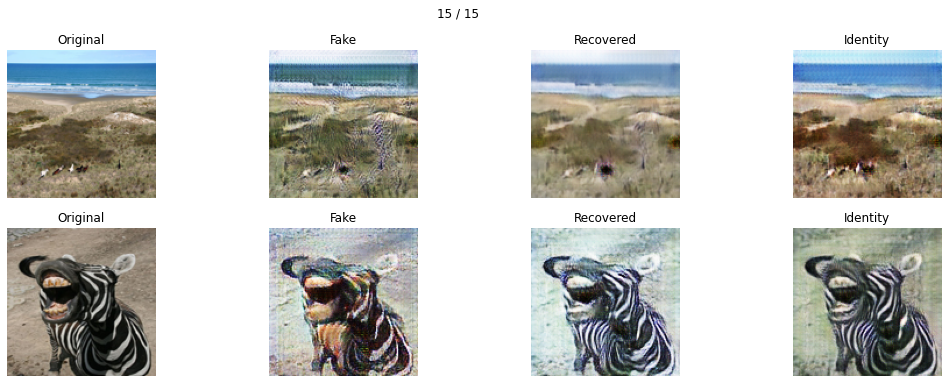

[14/15]	Loss_D_H: 0.8747	Loss_D_Z: 0.3621	Loss_G_Fool: 0.3543	Loss_G_Consistency: 0.2971	Loss_G_Identity: 0.2477


In [35]:
Original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_zebra, Recovered_zebra, Identity_zebra=train(A2B,B2A,Dis_A,Dis_B, optimizer_A,optimizer_B,optimizer_A2B,optimizer_B2A, 15, data_tr, data_val)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [39]:
#torch.save(Dis_A.state_dict(), 'drive/My Drive/DLiCV_project/Project3/Dis_A_23_june_'+str(n_blocks)+'blocks_15e')
#torch.save(Dis_B.state_dict(), 'drive/My Drive/DLiCV_project/Project3/Dis_B_23_june_'+str(n_blocks)+'blocks_15e')
#torch.save(A2B.state_dict(), 'drive/My Drive/DLiCV_project/Project3/A2B_23_june_'+str(n_blocks)+'blocks_15e')
#torch.save(B2A.state_dict(), 'drive/My Drive/DLiCV_project/Project3/B2A_23_june_'+str(n_blocks)+'blocks_15e')

#Test more pictures (saves last image for FID)

In [79]:
def more_pictures(A2B,B2A,Dis_A,Dis_B, opt_dis_A,opt_dis_B,opt_A2B,opt_B2A, epochs, data_tr, data_val):
  all_original_horses=[]
  all_fake_horses=[]
  all_recovered_horses=[]
  all_identity_horses=[]

  all_original_zebras=[]
  all_fake_zebras=[]
  all_recovered_zebras=[]
  all_identity_zebras=[]

  for epoch in range(epochs):
    X_val, Y_val = next(iter(data_val))
  ######## TEST ########
    X_val = X_val*2-1
    Y_val = Y_val*2-1

    A2B.eval()
    B2A.eval()
    Dis_A.eval()
    Dis_B.eval()


    #show intermediate results
    #Horse2zebra
    Original_horse=X_val
    Fake_horse=A2B(X_val.to(device))
    Recovered_horse=B2A(Fake_horse).detach().cpu()
    Identity_horse=B2A(X_val.to(device)).detach().cpu()
    


    #Horse2zebra
    Original_zebra=Y_val
    Fake_zebra=B2A(Y_val.to(device)).detach().cpu()
    Recovered_zebra=A2B(Fake_zebra.to(device)).detach().cpu()
    Identity_zebra=A2B(Y_val.to(device)).detach().cpu()


    X_val = X_val/2+0.5
    Original_horse = Original_horse/2+0.5
    Fake_horse = Fake_horse/2+0.5
    Recovered_horse = Recovered_horse/2+0.5
    Identity_horse = Identity_horse/2+0.5

    Y_val = Y_val/2+0.5
    Original_zebra = Original_zebra/2+0.5
    Fake_zebra = Fake_zebra/2+0.5
    Recovered_zebra = Recovered_zebra/2+0.5
    Identity_zebra = Identity_zebra/2+0.5

    all_original_horses.append(Original_horse)
    all_fake_horses.append(Fake_horse)
    all_recovered_horses.append(Recovered_horse)
    all_identity_horses.append(Identity_horse)
    all_original_zebras.append(Original_zebra)
    all_fake_zebras.append(Fake_zebra)
    all_recovered_zebras.append(Recovered_zebra)
    all_identity_zebras.append(Identity_zebra)


#clear_output(wait=True)
 
  
  plt.figure(1)
  plt.rcParams['figure.figsize'] = [15, 80]
  for k in range(epochs):
      #Plotting horses
      
      
      plt.subplot(2*epochs, 4, k+1)
      plt.imshow(all_original_horses[k][0].permute(1,2,0).numpy())
      #axarr[0,0].imshow(all_original_horses[k][0].permute(1,2,0).numpy())
      plt.title('Original')
      plt.axis('off')

      plt.subplot(2*epochs, 4, k+2)
      plt.imshow(all_fake_horses[k][0].permute(1,2,0).detach().cpu().numpy())
      plt.title('Fake')
      plt.axis('off')

      plt.subplot(2*epochs, 4, k+3)

      plt.imshow(all_recovered_horses[k][0].permute(1,2,0).detach().cpu().numpy())
      plt.title('Recovered')
      plt.axis('off')


      plt.subplot(2*epochs, 4, k+4)
      
      plt.imshow(all_identity_horses[k][0].permute(1,2,0).detach().cpu().numpy())
      plt.title('Identity')
      plt.axis('off')


      #Plotting zebras
      plt.subplot(2*epochs, 4, k+5)
      plt.imshow(all_original_zebras[k][0].permute(1,2,0).numpy())
      plt.title('Original')
      plt.axis('off')

      plt.subplot(2*epochs, 4, k+6)
      plt.imshow(all_fake_zebras[k][0].permute(1,2,0).detach().cpu().numpy())
      plt.title('Fake')
      plt.axis('off')

      plt.subplot(2*epochs, 4, k+7)
      
      plt.imshow(all_recovered_zebras[k][0].permute(1,2,0).detach().cpu().numpy())
      plt.title('Recovered')
      plt.axis('off')


      plt.subplot(2*epochs, 4, k+8)
      
      plt.imshow(all_identity_zebras[k][0].permute(1,2,0).detach().cpu().numpy())
      plt.title('Identity')
      plt.axis('off')
      plt.show()
  #plt.suptitle('%d / %d' % (epoch+1, epochs))
  #plt.show()
  return Original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_zebra, Recovered_zebra, Identity_zebra#return all_original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_Zebra, Recovered_zebra, Identity_zebra

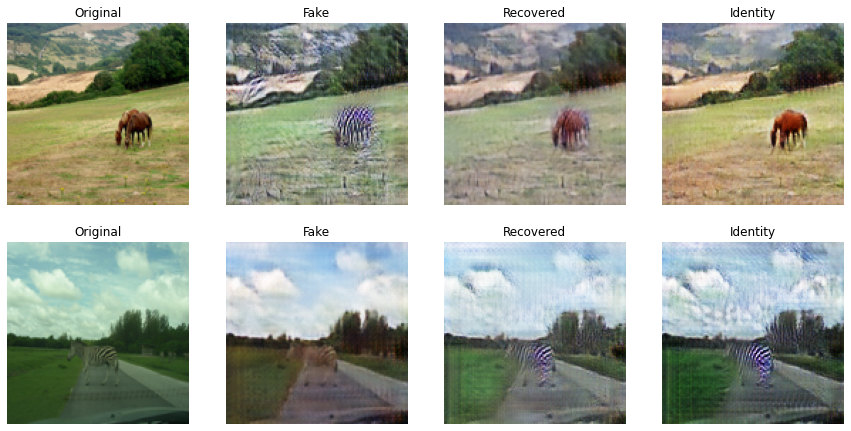

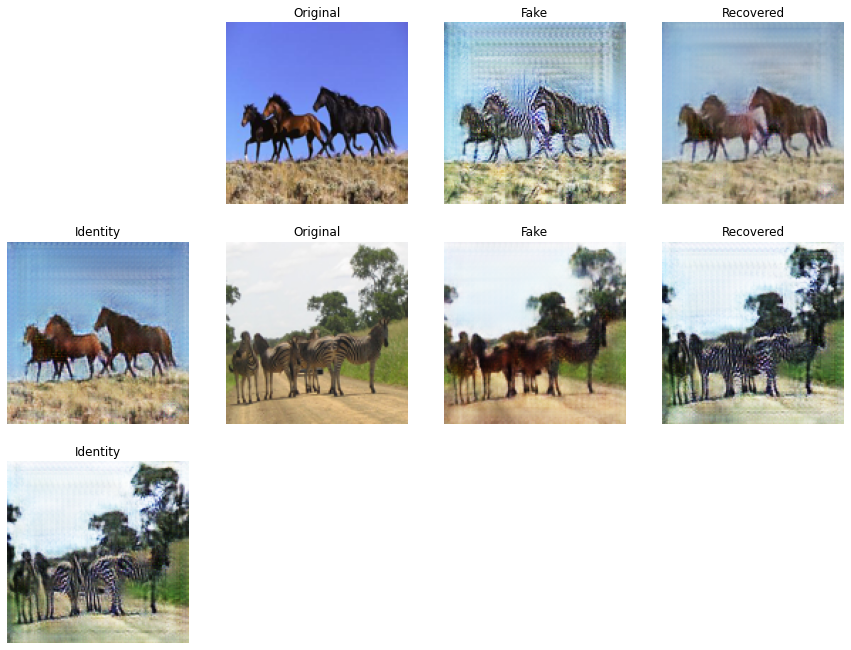

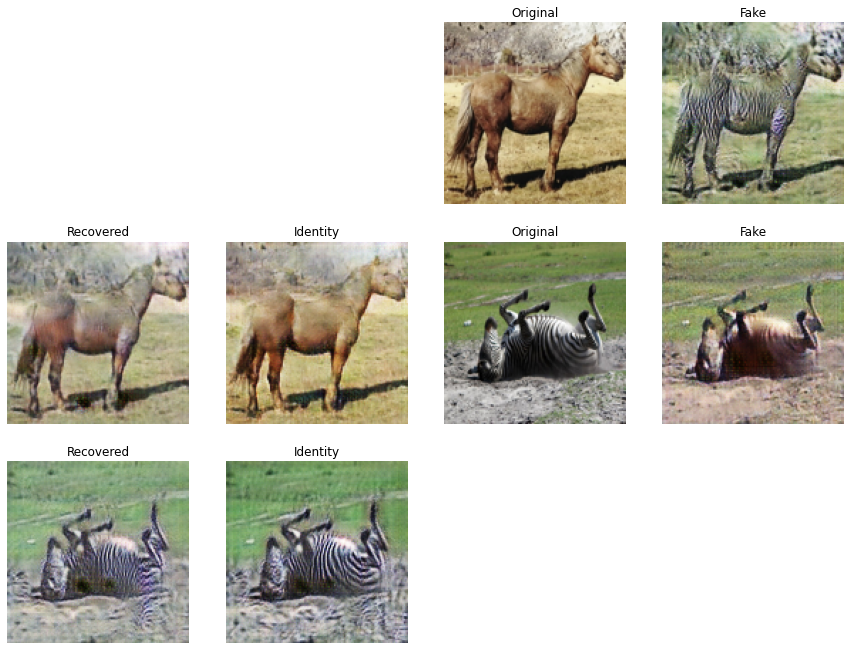

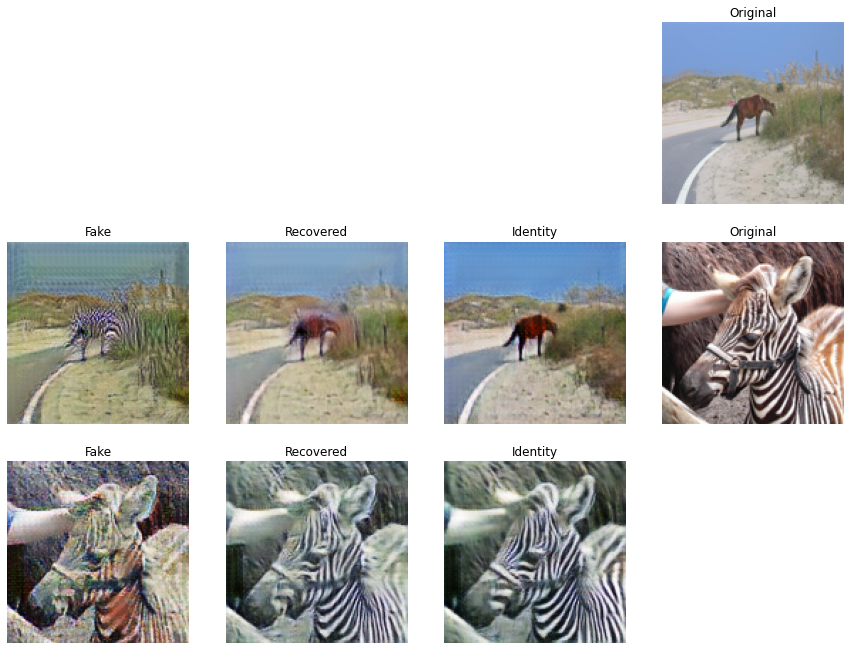

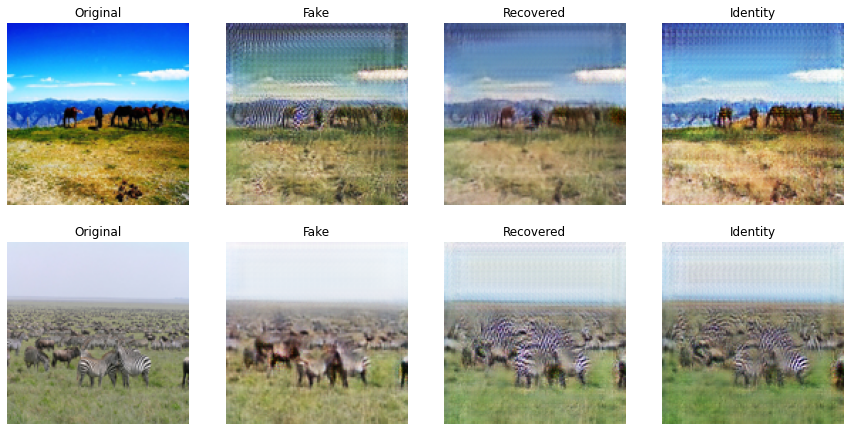

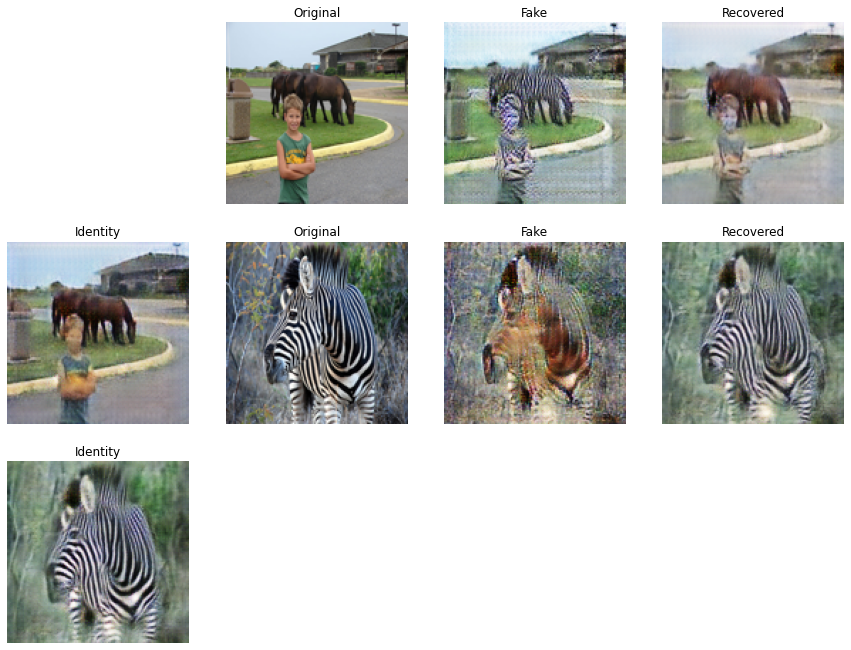

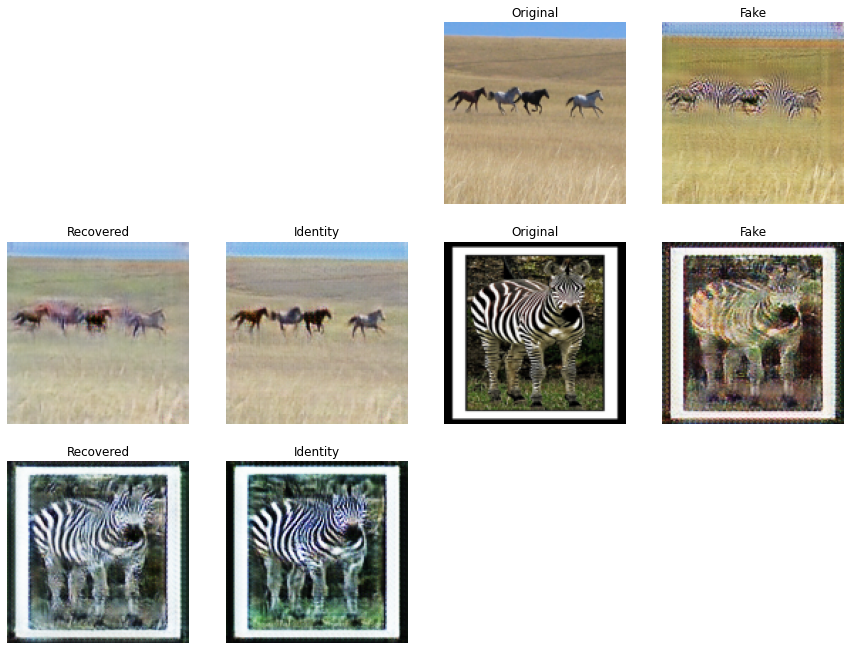

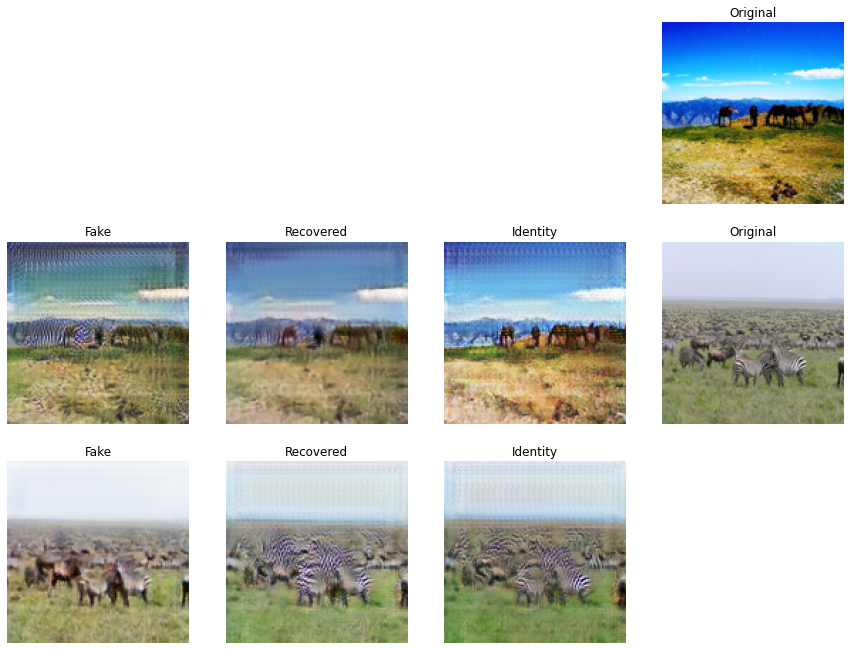

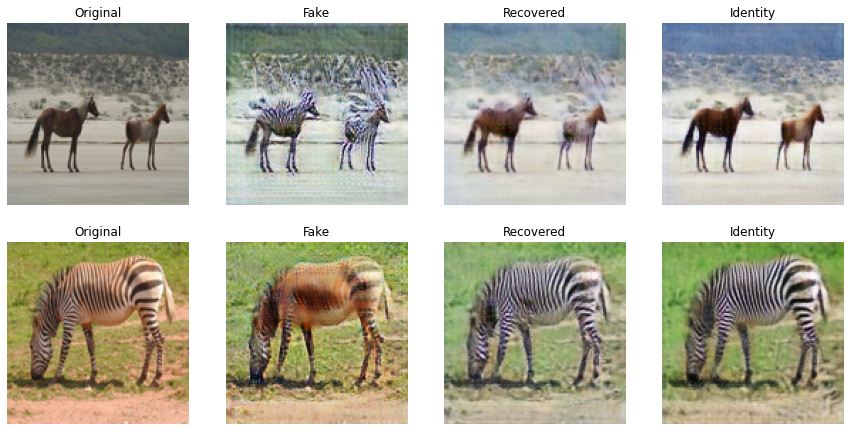

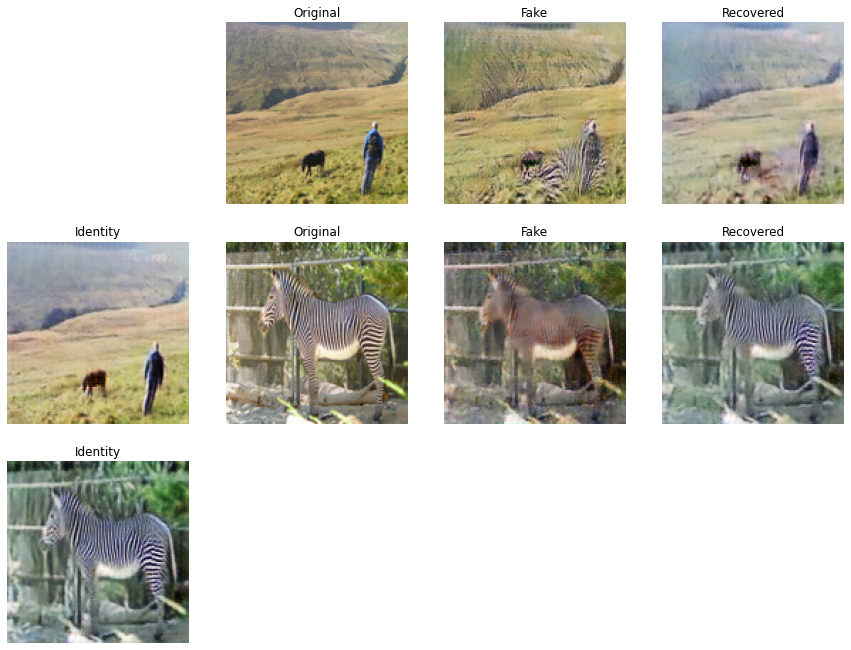

In [80]:
Original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_zebra, Recovered_zebra, Identity_zebra=more_pictures(A2B,B2A,Dis_A,Dis_B, None,None,None,None, 10, None, data_val)

# Frechet Inception Distance (uses 1 image)

FID measure taken from: https://github.com/mseitzer/pytorch-fid

Mounting drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import save function.

In [81]:
from torchvision.utils import save_image

Remove all images from folders:

In [82]:
import os
root1='./drive/My Drive/DLiCV_project/Project3/Horse_true/'
for ffile in os.listdir(root1):
  if ffile.endswith('.png'):
    os.remove(root1+ffile)

root2='./drive/My Drive/DLiCV_project/Project3/Zebra_true/'
for ffile in os.listdir(root2):
  if ffile.endswith('.png'):
    os.remove(root2+ffile)

root3='./drive/My Drive/DLiCV_project/Project3/Horse_generated/'
for ffile in os.listdir(root3):
  if ffile.endswith('.png'):
    os.remove(root3+ffile)

root4='./drive/My Drive/DLiCV_project/Project3/Zebra_generated/'
for ffile in os.listdir(root4):
  if ffile.endswith('.png'):
    os.remove(root4+ffile)


Save 3x original horse image and 3x original zebra

In [83]:
for i in [1,2,3]:
  save_image(Original_horse, './drive/My Drive/DLiCV_project/Project3/Horse_true/img'+str(i)+'.png')
  save_image(Original_zebra, './drive/My Drive/DLiCV_project/Project3/Zebra_true/img'+str(i)+'.png')

Save fake, recovered and identity horse:

In [84]:
save_image(Fake_horse, './drive/My Drive/DLiCV_project/Project3/Horse_generated/img1.png')

In [85]:
save_image(Recovered_horse, './drive/My Drive/DLiCV_project/Project3/Horse_generated/img2.png')

In [86]:
save_image(Identity_horse, './drive/My Drive/DLiCV_project/Project3/Horse_generated/img3.png')

Save fake, recovered and identity zebra

In [ ]:
save_image(Fake_zebra, './drive/My Drive/DLiCV_project/Project3/Zebra_generated/img1.png')

In [ ]:
save_image(Recovered_zebra, './drive/My Drive/DLiCV_project/Project3/Zebra_generated/img2.png')

In [ ]:
save_image(Identity_zebra, './drive/My Drive/DLiCV_project/Project3/Zebra_generated/img3.png')

## Calculate FID for horse images

In [ ]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Horse_generated/' './drive/My Drive/DLiCV_project/Project3/Horse_true/'

100% 1/1 [00:00<00:00,  1.11it/s]
100% 1/1 [00:00<00:00,  1.13it/s]
/usr/local/lib/python3.6/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:191: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
FID:  189.63800406455888


## Calculate FID for zebra images

In [ ]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Zebra_generated/' './drive/My Drive/DLiCV_project/Project3/Zebra_true/'

100% 1/1 [00:00<00:00,  1.16it/s]
100% 1/1 [00:00<00:00,  1.14it/s]
/usr/local/lib/python3.6/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:191: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
FID:  59.088423003638525


#Test more pictures ( Saves 50 images for FID)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:

Dis_A =Discriminator().to(device)
Dis_A.load_state_dict(torch.load('drive/My Drive/DLiCV_project/Project3/Dis_A_23_june_'+str(n_blocks)+'blocks_15e'))
Dis_A.eval()

Dis_B =Discriminator().to(device)
Dis_B.load_state_dict(torch.load('drive/My Drive/DLiCV_project/Project3/Dis_B_23_june_'+str(n_blocks)+'blocks_15e'))
Dis_B.eval()

A2B = Generator().to(device)
A2B.load_state_dict(torch.load('drive/My Drive/DLiCV_project/Project3/A2B_23_june_'+str(n_blocks)+'blocks_15e'))
A2B.eval()

B2A = Generator().to(device)
B2A.load_state_dict(torch.load('drive/My Drive/DLiCV_project/Project3/B2A_23_june_'+str(n_blocks)+'blocks_15e'))
B2A.eval()



Generator(
  (conv): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResBlock(
      (conv): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm): 

In [93]:
print_pic=0

In [94]:
def more_pictures_v2(A2B,B2A,Dis_A,Dis_B, opt_dis_A,opt_dis_B,opt_A2B,opt_B2A, epochs, data_tr, data_val):
  all_original_horses=[]
  all_fake_horses=[]
  all_recovered_horses=[]
  all_identity_horses=[]

  all_original_zebras=[]
  all_fake_zebras=[]
  all_recovered_zebras=[]
  all_identity_zebras=[]

  for epoch in range(epochs):
    X_val, Y_val = next(iter(data_val))
  ######## TEST ########
    X_val = X_val*2-1
    Y_val = Y_val*2-1

    A2B.eval()
    B2A.eval()
    Dis_A.eval()
    Dis_B.eval()


    #show intermediate results
    #Horse2zebra
    Original_horse=X_val
    Fake_horse=A2B(X_val.to(device))
    Recovered_horse=B2A(Fake_horse).detach().cpu()
    Identity_horse=B2A(X_val.to(device)).detach().cpu()

    


    #Horse2zebra
    Original_zebra=Y_val
    Fake_zebra=B2A(Y_val.to(device)).detach().cpu()
    Recovered_zebra=A2B(Fake_zebra.to(device)).detach().cpu()
    Identity_zebra=A2B(Y_val.to(device)).detach().cpu()

    X_val = X_val/2+0.5
    Original_horse = Original_horse/2+0.5
    Fake_horse = Fake_horse/2+0.5
    Recovered_horse = Recovered_horse/2+0.5
    Identity_horse = Identity_horse/2+0.5

    Y_val = Y_val/2+0.5
    Original_zebra = Original_zebra/2+0.5
    Fake_zebra = Fake_zebra/2+0.5
    Recovered_zebra = Recovered_zebra/2+0.5
    Identity_zebra = Identity_zebra/2+0.5

    all_original_horses.append(Original_horse)
    all_fake_horses.append(Fake_horse)
    all_recovered_horses.append(Recovered_horse)
    all_identity_horses.append(Identity_horse)

    all_original_zebras.append(Original_zebra)
    all_fake_zebras.append(Fake_zebra)
    all_recovered_zebras.append(Recovered_zebra)
    all_identity_zebras.append(Identity_zebra)


#clear_output(wait=True)
  if print_pic==1:
    plt.rcParams['figure.figsize'] = [20, 40]
    for k in range(epochs):
        #Plotting horses
        plt.figure(k)
        
        plt.subplot(2*epochs, 4, k+1)
        plt.imshow(all_original_horses[k][0].permute(1,2,0).numpy())
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2*epochs, 4, k+2)
        plt.imshow(all_fake_horses[k][0].permute(1,2,0).detach().cpu().numpy())
        plt.title('Fake')
        plt.axis('off')

        plt.subplot(2*epochs, 4, k+3)

        plt.imshow(all_recovered_horses[k][0].permute(1,2,0).detach().cpu().numpy())
        plt.title('Recovered')
        plt.axis('off')


        plt.subplot(2*epochs, 4, k+4)
        
        plt.imshow(all_identity_horses[k][0].permute(1,2,0).detach().cpu().numpy())
        plt.title('Identity')
        plt.axis('off')


        #Plotting zebras
        plt.subplot(2*epochs, 4, k+5)
        plt.imshow(all_original_zebras[k][0].permute(1,2,0).numpy())
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2*epochs, 4, k+6)
        plt.imshow(all_fake_zebras[k][0].permute(1,2,0).detach().cpu().numpy())
        plt.title('Fake')
        plt.axis('off')

        plt.subplot(2*epochs, 4, k+7)
        
        plt.imshow(all_recovered_zebras[k][0].permute(1,2,0).detach().cpu().numpy())
        plt.title('Recovered')
        plt.axis('off')


        plt.subplot(2*epochs, 4, k+8)
        
        plt.imshow(all_identity_zebras[k][0].permute(1,2,0).detach().cpu().numpy())
        plt.title('Identity')
        plt.axis('off')
        plt.show()
  #plt.suptitle('%d / %d' % (epoch+1, epochs))
  #plt.show()
  #return Original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_Zebra, Recovered_zebra, Identity_zebra
  return all_original_horses, all_fake_horses, all_recovered_horses, all_identity_horses,all_original_zebras, all_fake_zebras, all_recovered_zebras, all_identity_zebras

In [95]:
n_epochs=50

In [96]:
Original_horse, Fake_horse, Recovered_horse, Identity_horse,Original_zebra, Fake_zebra, Recovered_zebra, Identity_zebra=more_pictures_v2(A2B,B2A,Dis_A,Dis_B, None,None,None,None, n_epochs, None, data_val)

# Frechet Inception Distance (uses 50 images)

FID measure taken from: https://github.com/mseitzer/pytorch-fid

Mounting drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import save function.

In [ ]:
from torchvision.utils import save_image

Remove all images from folders:

In [ ]:
import os
root1='./drive/My Drive/DLiCV_project/Project3/Horse_true/'
for ffile in os.listdir(root1):
  if ffile.endswith('.png'):
    os.remove(root1+ffile)

root2='./drive/My Drive/DLiCV_project/Project3/Zebra_true/'
for ffile in os.listdir(root2):
  if ffile.endswith('.png'):
    os.remove(root2+ffile)

root3='./drive/My Drive/DLiCV_project/Project3/Horse_generated/'
for ffile in os.listdir(root3):
  if ffile.endswith('.png'):
    os.remove(root3+ffile)

root4='./drive/My Drive/DLiCV_project/Project3/Zebra_generated/'
for ffile in os.listdir(root4):
  if ffile.endswith('.png'):
    os.remove(root4+ffile)


Save 3x original horse image and 3x original zebra

In [ ]:
for i in range(n_epochs):
  for j in [1,2,3]:
    save_image(Original_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_true/img'+str(10000+i*3+j)+'.png')
    save_image(Original_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_true/img'+str(10000+i*3+j)+'.png')

Save fake, recovered and identity horse:

In [ ]:
k=1
for i in range(n_epochs):
  save_image(Fake_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_generated/img'+str(10000+k)+'.png')
  k=k+1
  save_image(Recovered_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_generated/img'+str(10000+k)+'.png')
  k=k+1
  save_image(Identity_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_generated/img'+str(10000+k)+'.png')
  k=k+1

Save fake, recovered and identity zebra

In [ ]:
k=1
for i in range(n_epochs):
  save_image(Fake_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_generated/img'+str(10000+k)+'.png')
  k=k+1
  save_image(Recovered_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_generated/img'+str(10000+k)+'.png')
  k=k+1
  save_image(Identity_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_generated/img'+str(10000+k)+'.png')
  k=k+1

## Calculate FID for horse images

In [ ]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Horse_generated/' './drive/My Drive/DLiCV_project/Project3/Horse_true/'

100% 3/3 [00:30<00:00, 10.27s/it]
100% 3/3 [00:29<00:00,  9.94s/it]
FID:  215.90313835834303


## Calculate FID for zebra images

In [ ]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Zebra_generated/' './drive/My Drive/DLiCV_project/Project3/Zebra_true/'

100% 3/3 [00:30<00:00, 10.02s/it]
100% 3/3 [00:28<00:00,  9.65s/it]
FID:  109.88876522032248


# Frechet Inception Distance (individual)

FID measure taken from: https://github.com/mseitzer/pytorch-fid

Mounting drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import save function.

In [97]:
from torchvision.utils import save_image

Remove all images from folders:

In [98]:
import os
root1='./drive/My Drive/DLiCV_project/Project3/Horse_true/'
for ffile in os.listdir(root1):
  if ffile.endswith('.png'):
    os.remove(root1+ffile)

root2='./drive/My Drive/DLiCV_project/Project3/Zebra_true/'
for ffile in os.listdir(root2):
  if ffile.endswith('.png'):
    os.remove(root2+ffile)

root3='./drive/My Drive/DLiCV_project/Project3/Horse_generated/'
for ffile in os.listdir(root3):
  if ffile.endswith('.png'):
    os.remove(root3+ffile)

root4='./drive/My Drive/DLiCV_project/Project3/Zebra_generated/'
for ffile in os.listdir(root4):
  if ffile.endswith('.png'):
    os.remove(root4+ffile)




root5='./drive/My Drive/DLiCV_project/Project3/Horse_recovered/'
for ffile in os.listdir(root5):
  if ffile.endswith('.png'):
    os.remove(root5+ffile)

root6='./drive/My Drive/DLiCV_project/Project3/Zebra_recovered/'
for ffile in os.listdir(root6):
  if ffile.endswith('.png'):
    os.remove(root6+ffile)


root7='./drive/My Drive/DLiCV_project/Project3/Horse_fake/'
for ffile in os.listdir(root7):
  if ffile.endswith('.png'):
    os.remove(root7+ffile)

root8='./drive/My Drive/DLiCV_project/Project3/Zebra_fake/'
for ffile in os.listdir(root8):
  if ffile.endswith('.png'):
    os.remove(root8+ffile)

root9='./drive/My Drive/DLiCV_project/Project3/Horse_identity/'
for ffile in os.listdir(root9):
  if ffile.endswith('.png'):
    os.remove(root9+ffile)


root10='./drive/My Drive/DLiCV_project/Project3/Zebra_identity/'
for ffile in os.listdir(root10):
  if ffile.endswith('.png'):
    os.remove(root10+ffile)


Save 1x original horse image and 1x original zebra

In [99]:
k=1
for i in range(n_epochs):
  #for j in [1,2,3]:
    save_image(Original_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_true/img'+str(10000+k)+'.png')
    k=k+1
    save_image(Original_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_true/img'+str(10000+i)+'.png')
    k=k+1

Save fake, recovered and identity horse:

In [100]:
k=1
for i in range(n_epochs):
  save_image(Fake_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_fake/img'+str(10000+k)+'.png')
  save_image(Recovered_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_recovered/img'+str(10000+k)+'.png')
  save_image(Identity_horse[i], './drive/My Drive/DLiCV_project/Project3/Horse_identity/img'+str(10000+k)+'.png')
  k=k+1

Save fake, recovered and identity zebra

In [101]:
k=1
for i in range(n_epochs):
  save_image(Fake_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_fake/img'+str(10000+k)+'.png')
  k=k+1
  save_image(Recovered_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_recovered/img'+str(10000+k)+'.png')
  k=k+1
  save_image(Identity_zebra[i], './drive/My Drive/DLiCV_project/Project3/Zebra_identity/img'+str(10000+k)+'.png')
  k=k+1

## Calculate FID for horse images

Fake:

In [102]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Horse_fake/' './drive/My Drive/DLiCV_project/Project3/Horse_true/'

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:02<00:00, 41.2MB/s]
100% 1/1 [00:13<00:00, 13.32s/it]
100% 1/1 [00:12<00:00, 12.84s/it]
FID:  268.81848168572617


Revocer:

In [103]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Horse_recovered/' './drive/My Drive/DLiCV_project/Project3/Horse_true/'

100% 1/1 [00:12<00:00, 12.88s/it]
100% 1/1 [00:12<00:00, 12.46s/it]
FID:  172.11318845563736


Identity

In [104]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Horse_identity/' './drive/My Drive/DLiCV_project/Project3/Horse_true/'

100% 1/1 [00:12<00:00, 12.77s/it]
100% 1/1 [00:12<00:00, 12.23s/it]
FID:  136.57837880782617


## Calculate FID for zebra images

Fake:

In [105]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Zebra_fake/' './drive/My Drive/DLiCV_project/Project3/Zebra_true/'

100% 1/1 [00:12<00:00, 12.70s/it]
100% 1/1 [00:12<00:00, 12.37s/it]
FID:  204.98433167912708


Recover

In [106]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Zebra_recovered/' './drive/My Drive/DLiCV_project/Project3/Zebra_true/'

100% 1/1 [00:12<00:00, 12.72s/it]
100% 1/1 [00:11<00:00, 11.95s/it]
FID:  84.9126763747147


Identity

In [107]:
!python './drive/My Drive/DLiCV_project/Project3/fid_score.py' './drive/My Drive/DLiCV_project/Project3/Zebra_identity/' './drive/My Drive/DLiCV_project/Project3/Zebra_true/'

100% 1/1 [00:12<00:00, 12.52s/it]
100% 1/1 [00:12<00:00, 12.20s/it]
FID:  63.42046691790905
